# PyMGA
PyMGA is a python package for performing Modeling All Alternatives (MAA) analysis on linear optimization problems. The methods are applicable for models of any format, but examples are provided for use with the PyPSA energy system modeling framework.

### Installing PyMGA
PyMGA is not yet available on pypi. This guide assumes you have Anaconda installed. To install PyMGA manually, follow these steps:
1. Clone the PyMGA repository from https://github.com/LukasBNordentoft/PyMGA_LBN/
2. Navigate to the cloned repository on your computer, typically in a folder path like C:\Users\Github\PyMGA_LBN. Copy the folder path.
3. Open Anaconda prompt, and navigate to the path you just copied, such as: <br/> ```cd C:\Users\Github\PyMGA_LBN```
4. Install the PyMGA package from the folder by running <br/> ```pip install .```
5. Installing PyMGA will install all dependent packages
6. A successful install will return <br/> ```Processing C:/path/to/src/PyMGA  ``` <br/> ```Installing collected packages: PyMGA ``` <br/> ```Running setup.py install for PyMGA ... done ``` <br/> ```Successfully installed PyMGA-0.0.1 ```
7. PyMGA can now be imported with <br/> ```import PyMGA```

### PyMGA Limitations
Current limitations and known major problems:
* To run a PyPSA network with PyMGA, the PyPSA network must have 8760 snapshots. 
* PyPSA Networks must be loaded from a .nc file, and cannot be passed as network objects. 
### PyPSA Examples
PyMGA comes with a couple of PyPSA examples in the PyMGA_LBN/Examples folder. 
* The "3-bus_network" example contains a very simple PyPSA network, and is a good starting point
* The "island" example is more complicated, and contains custom constraints passed via extra_functionalities. If you have custom constraints, see this example. 

# GUIDE: Using a PyPSA network with PyMGA
Apart from the MAA methods, PyMGA contains examples and useful helper functions for exploring the near-optimal spaces, plotting and more. This following guide will go through a slightly modified version of the 3-bus_network example, as follows:
1. Loading the example PyPSA network "example_3-bus_network.nc" 
2. Running and MAA analysis on select network components
3. Calculating the Chebyshev center of the near-optimal space
4. Sampling the near-optimal space
5. Plotting the near-optimal space in a matrix plot representing all dimension combination

### Importing
We import PyMGA and yaml. Solver options are loaded from a .yaml file. The pypsa network for the analysis is loaded from a .nc file. Any network passed to PyMGA must be a saved .nc network, not a PyPSA network object.
This part assumes that this notebook is running in the same folder as the "example_3-bus_network.nc" and 'config.yaml' files. Otherwise, update the filepaths. 

In [1]:
import PyMGA
import yaml

# Load options from configuration file
with open('config.yaml') as f:
    config = yaml.safe_load(f)
    
# Load network
network_path = 'example_3-bus_network.nc'

### Set up MAA options
Set the number of boundary points to find, and the components in the system to explore (MAA variables).
Note that as the amount of MAA variables (dimensions) increase, you need at least 2 times the amount of MAA variables to find the minimum and maximum for each variable, and much more to find most of the near-optimal space. 
The MAA variable definitions are stored in a dictionary, with a list entry for each variable, in the form:
```
'Variable name':['Component_type', 
                ['Carrier1', 'Carrier2', ..., 'CarrierN'],
                'Attribute_to_explore' ]

Such as:
'Renewables':['Generator', 
             ['wind', 'solar', 'hydro'], 
             'p_nom' ]
```
Looking at the example, the MAA variable is defined by finding all Generators with the wind, solar or hydro carriers. The atttribute to explore is set to p_nom, so the possible near-optimal nominal capacities for this group of technologies will be explored. 

In [2]:
# Number of points to find on the boundary of the near-optimal space
n_boundary_points = 16

# Set MAA variables to explore
variables = {'x1': ['Generator', # Component type
                   ['wind'],     # Carrier(s)
                   'p_nom',],    # Component attribute to explore
             'x2': ['Generator',
                   ['coal'],
                   'p_nom',],
              'x3': ['Generator',
                    ['solar'],
                    'p_nom',],
             } 

### Build PyMGA case object
The pypsa network must be turned into a ```case``` object for PyMGA. This is done using the ```PyPSA_to_case()``` method. This is where all PyPSA-specific inputs are provided. ```PyPSA_to_case()``` needs the following inputs:

|             |              |
|-------------|:-------------|
|**config**       | The config file with solver options |
|**network_path** | The path to the .nc PyPSA network file. |
|**variables**    | Dict of variables |
| **mga_slack**   | Allowed slack to explore the near-optimal space |


In [3]:
# PyMGA: Build case from PyPSA network
case = PyMGA.cases.PyPSA_to_case(config, 
                                 network_path,
                                 variables = variables,
                                 mga_slack = 0.1,
                                 )

### Running the MAA analysis
To run the MAA analysis, an MAA method must be chosen. The available methods are:
* **MAA**: Find the near-optimal space by calculating the ConvexHull and searching in face-normal directions. Do not use above 8-9 dimensions, ConvexHull cannot handle it.
* **bMAA**: Find the near-optimal space by representing it as a combination of hyperplanes. Samples outer hull to identify search direction. Can be used in any number of dimensions.
* **MGA**: Find the near-optimal space by taking a random search direction. (Not recommended)

Using the chosen method, the ```case``` object is used to construct the ```method``` object. The ```find_optimum()``` method of the ```method``` object must be called to solve the optimum system. This returns the optimal solution, the objective value and the solved PyPSA network.

With the optimum solved, the ```search_directions()``` method of the ```method``` object can be called, to perform the MAA analysis. Here, the number of bonudary points to find is defined via ```n_samples```, and the amount of CPU threads to use is set via ```n_workers```. 
```search_directions()``` returns the vertices of the near-optimal space, as well as each direction associated with each vertex. 

In [4]:
# PyMGA: Choose MAA method
method = PyMGA.methods.bMAA(case) 
# method = PyMGA.methods.MAA(case) 
# method = PyMGA.methods.MGA(case) 

# PyMGA: Solve optimal system
opt_sol, obj, n_solved = method.find_optimum()

# PyMGA: Search near-optimal space using chosen method
vertices, directions, _, _ = method.search_directions(n_samples = n_boundary_points,
                                                       n_workers = 16)


 PyMGA: Finding optimal system 

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-22
Read LP format model from file C:\Users\au592788\OneDrive - Aarhus universitet\Dokumenter\Github\PyMGA_LBN\examples\PyPSA to PyMGA guide\tmp\pypsa-problem-dtlgv86l.lp
Reading time = 0.24 seconds
obj: 140160 rows, 61327 columns, 249676 nonzeros
Set parameter Threads to value 2
Set parameter Method to value 2
Set parameter Crossover to value 0
Set parameter BarConvTol to value 1e-06
Set parameter Seed to value 123
Set parameter AggFill to value 0
Set parameter PreDual to value 0
Set parameter GURO_PAR_BARDENSETHRESH to value 200

 PyMGA: Optimal system found 
 obj. value: 19666679.71 
 Time used: 5.43


 PyMGA: Searching near-optimal space using bMAA method 

initializing directions
searching in 8 directions
checking validity of samples
Hit and run sampling, 5000 samples
Iteration #4999,
                   total verticies 8,
                   acceptance rate 0.166

### Sampling the near-optimal space
Sampling the near-optimal space is one of the main strenghts of MAA. For this example system, 1 million near-optimal systems can be obtained quickly, all of which are feasible and with 10% or less increase in objective function value. 

To sample the near-optimal space, the following samplers are available:
* **Bayesian Bootstrap sampler**: Uses ConvexHull to compute simplexes and sample evenly. Very fast, but does not work above 8-9 dimensions.
* **Hit-and-run sampler**: Uses hyperplanes as boundaries and samples between them. Slower, but works in any dimensions. 

As this example is low-dimensional, the bayesian sampler is used.

In [5]:
# PyMGA: Sample the near-optimal space

# Bayesian bootstrap sampler, good up to around 8 dimensions
samples = PyMGA.sampler.bayesian_sample(1_000_000, vertices) 

# Hit-and-Run sampler, slower but works in any dimensions.
# samples = PyMGA.sampler.har_sample(1_000_000, x0 = np.zeros(len(variables.keys())), 
#                                    directions = directions, verticies = vertices)


### OPTIONAL: Calculating the Chebyshev Center
The chebyshev center is the center of the largest inscribed ball within the near-optimal space. PyMGA has the ```calculate_cheb``` function for calculating the Chebyshev center. For low-dimension cases (<=7), it is calculated with the more accurate ConvexHull, for high-dimension cases (>7) it uses less accurate hyperplanes. It just takes the vertices and directions as input, and returns the Chebyshev center and radius.

In [6]:
from PyMGA.utilities.general import calculate_cheb
cheb_center, cheb_radius = calculate_cheb(vertices, directions)

### OPTIONAL: Plotting the near-optimal space
PyMGA contains plotting functions to visualize the near-optimal space. 

**near_optimal_space_matrix**
As a potentially high-dimensional polytope, the near-optimal space can be hard to visualize. One way is to use a matrix plot, plotting every dimension against all others. This can be done using the function ```near_optimal_space_matrix()``` from PyMGA.utilities.plot. 

For ```near_optimal_space_matrix()```, the variable names and vertices are required inputs. Some of the most important inputs include:
* **samples**: Pass numpy array of samples from the near-optimal space. This will show the densities in each dimension pari, as well as a distribution for each variable and correlations betwen each dimension pair.
* **opt_solution**: Pass list containing the optimal solution coordinates. This will plot the optimal solution, to see where it lies within the near-optimal space. 
* **cheb_center**: Pass list containing the Chebyshev Center coordinates. This will plot the chebyshev center, for comparison.
* **plot_vertices**: If True, will plot the vertices on the boundaries of the near-optimal space. 
* **plot_boundary**: If False, will not plot the boundary. Useful if you have a sample cloud.  
* **filename**: Pass a filename string ending in .pdf to save plot.

**near_optimal_space_slice**
While the matrix plot is useful, it can quickly become cluttered. When focusing on just one of the many dimension pairs, the function ```near_optimal_space_slice()``` is useful. This shows the "d projection of the near-optimal space of a chosen dimension pair, along with their distributions. 

For ```near_optimal_space_slice()```, the required inputs are all the variable names, the names of the chosen variables, the vertices and the samples. Optional inputs are opt_solution, cheb_center and filename, which works as in the matrix plot. 

**Plotting a slice of the near-optimal space:**

array([<Axes: title={'center': 'Near-optimal space'}, xlabel='x1', ylabel='x2'>,
       <Axes: title={'center': 'Histograms'}, xlabel='Variable value', ylabel='Probability'>],
      dtype=object)

<Figure size 3000x1500 with 0 Axes>

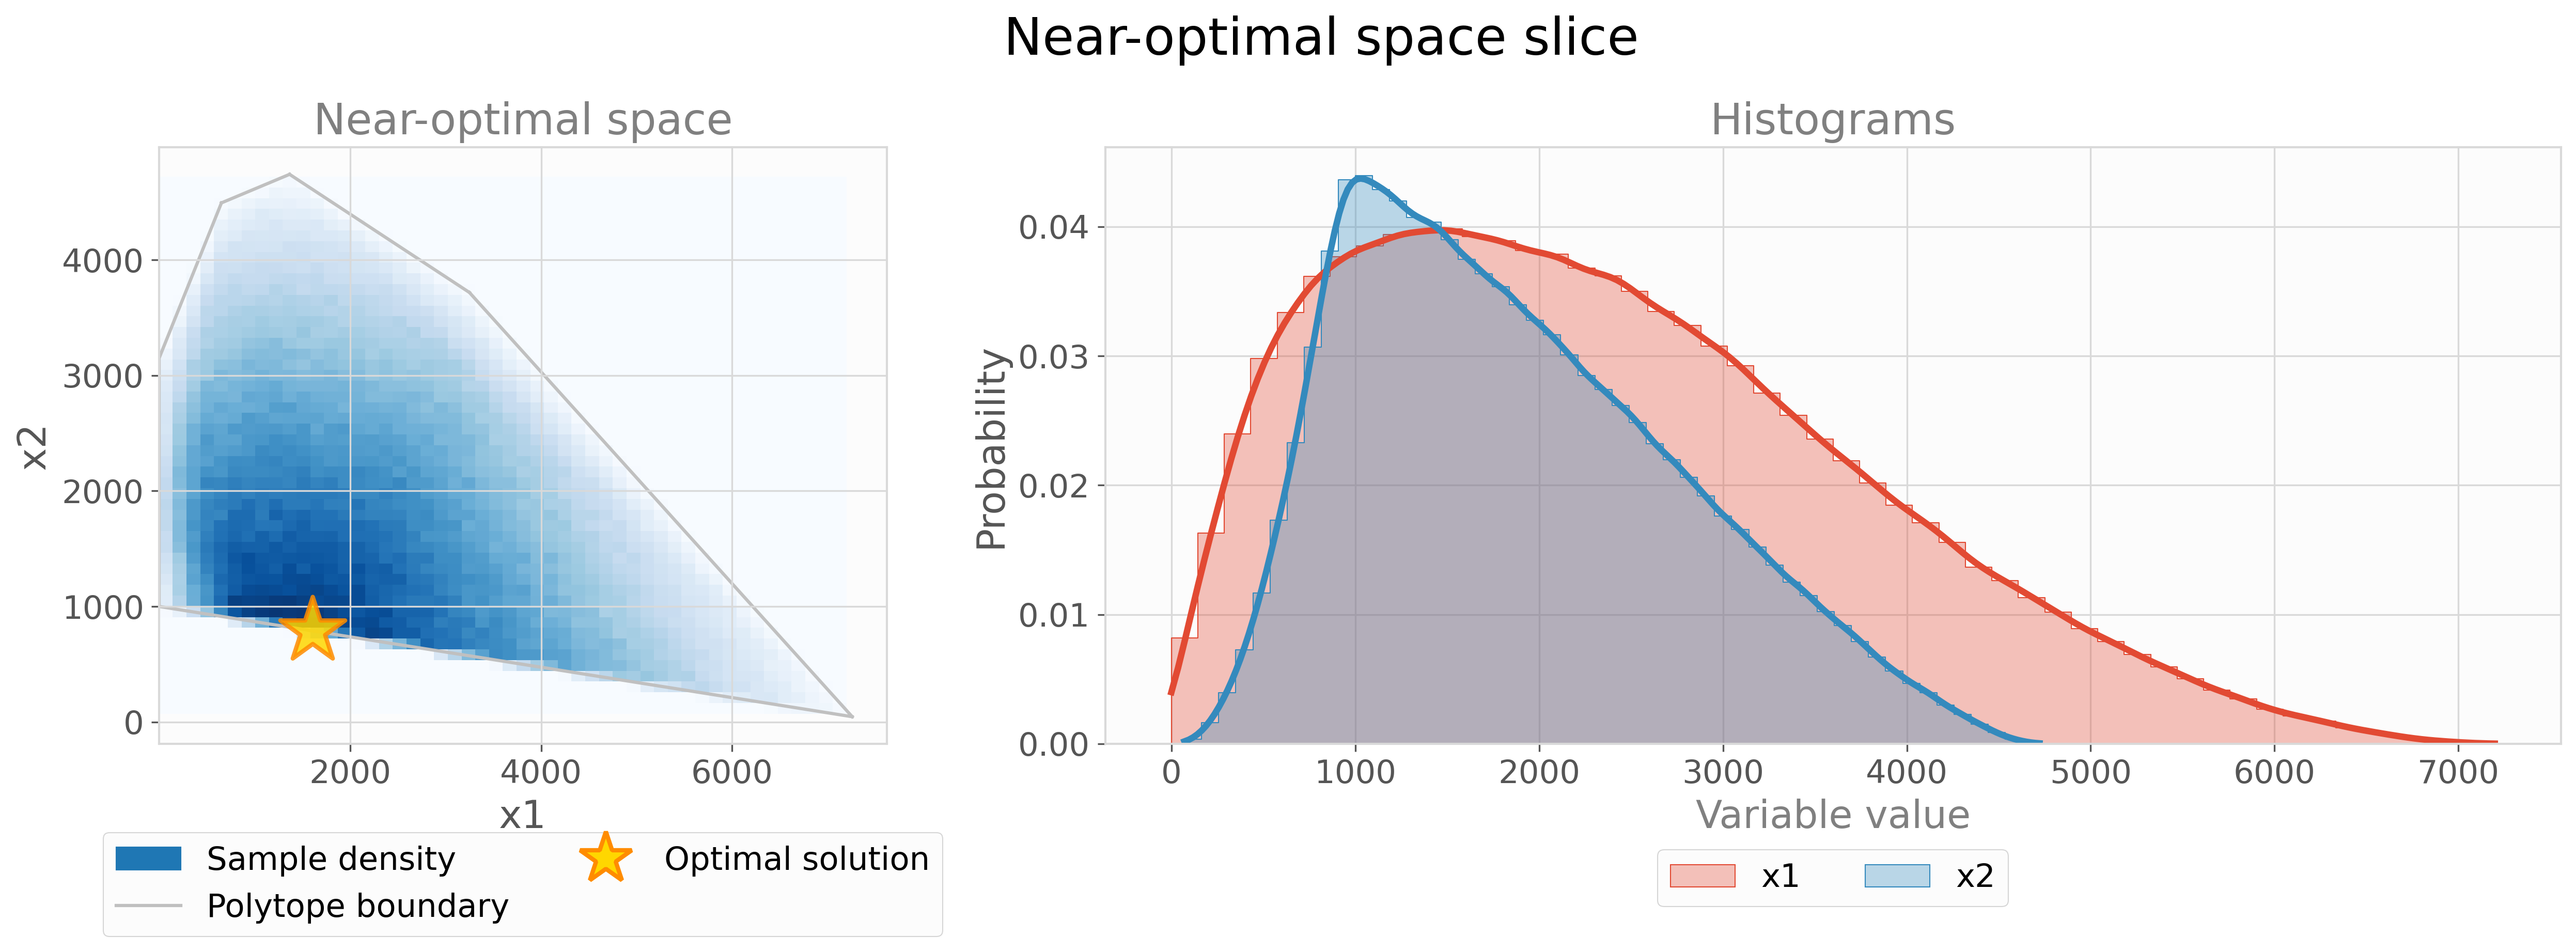

In [7]:
from PyMGA.utilities.plot import near_optimal_space_slice

# The near-optimal space slice plot
near_optimal_space_slice(all_variables = list(variables.keys()), 
                         chosen_variables = ['x1', 'x2'], 
                         vertices = vertices, 
                         samples = samples,
                         opt_solution = opt_sol,
                         )

**Plotting the entire near-optimal space matrix:**

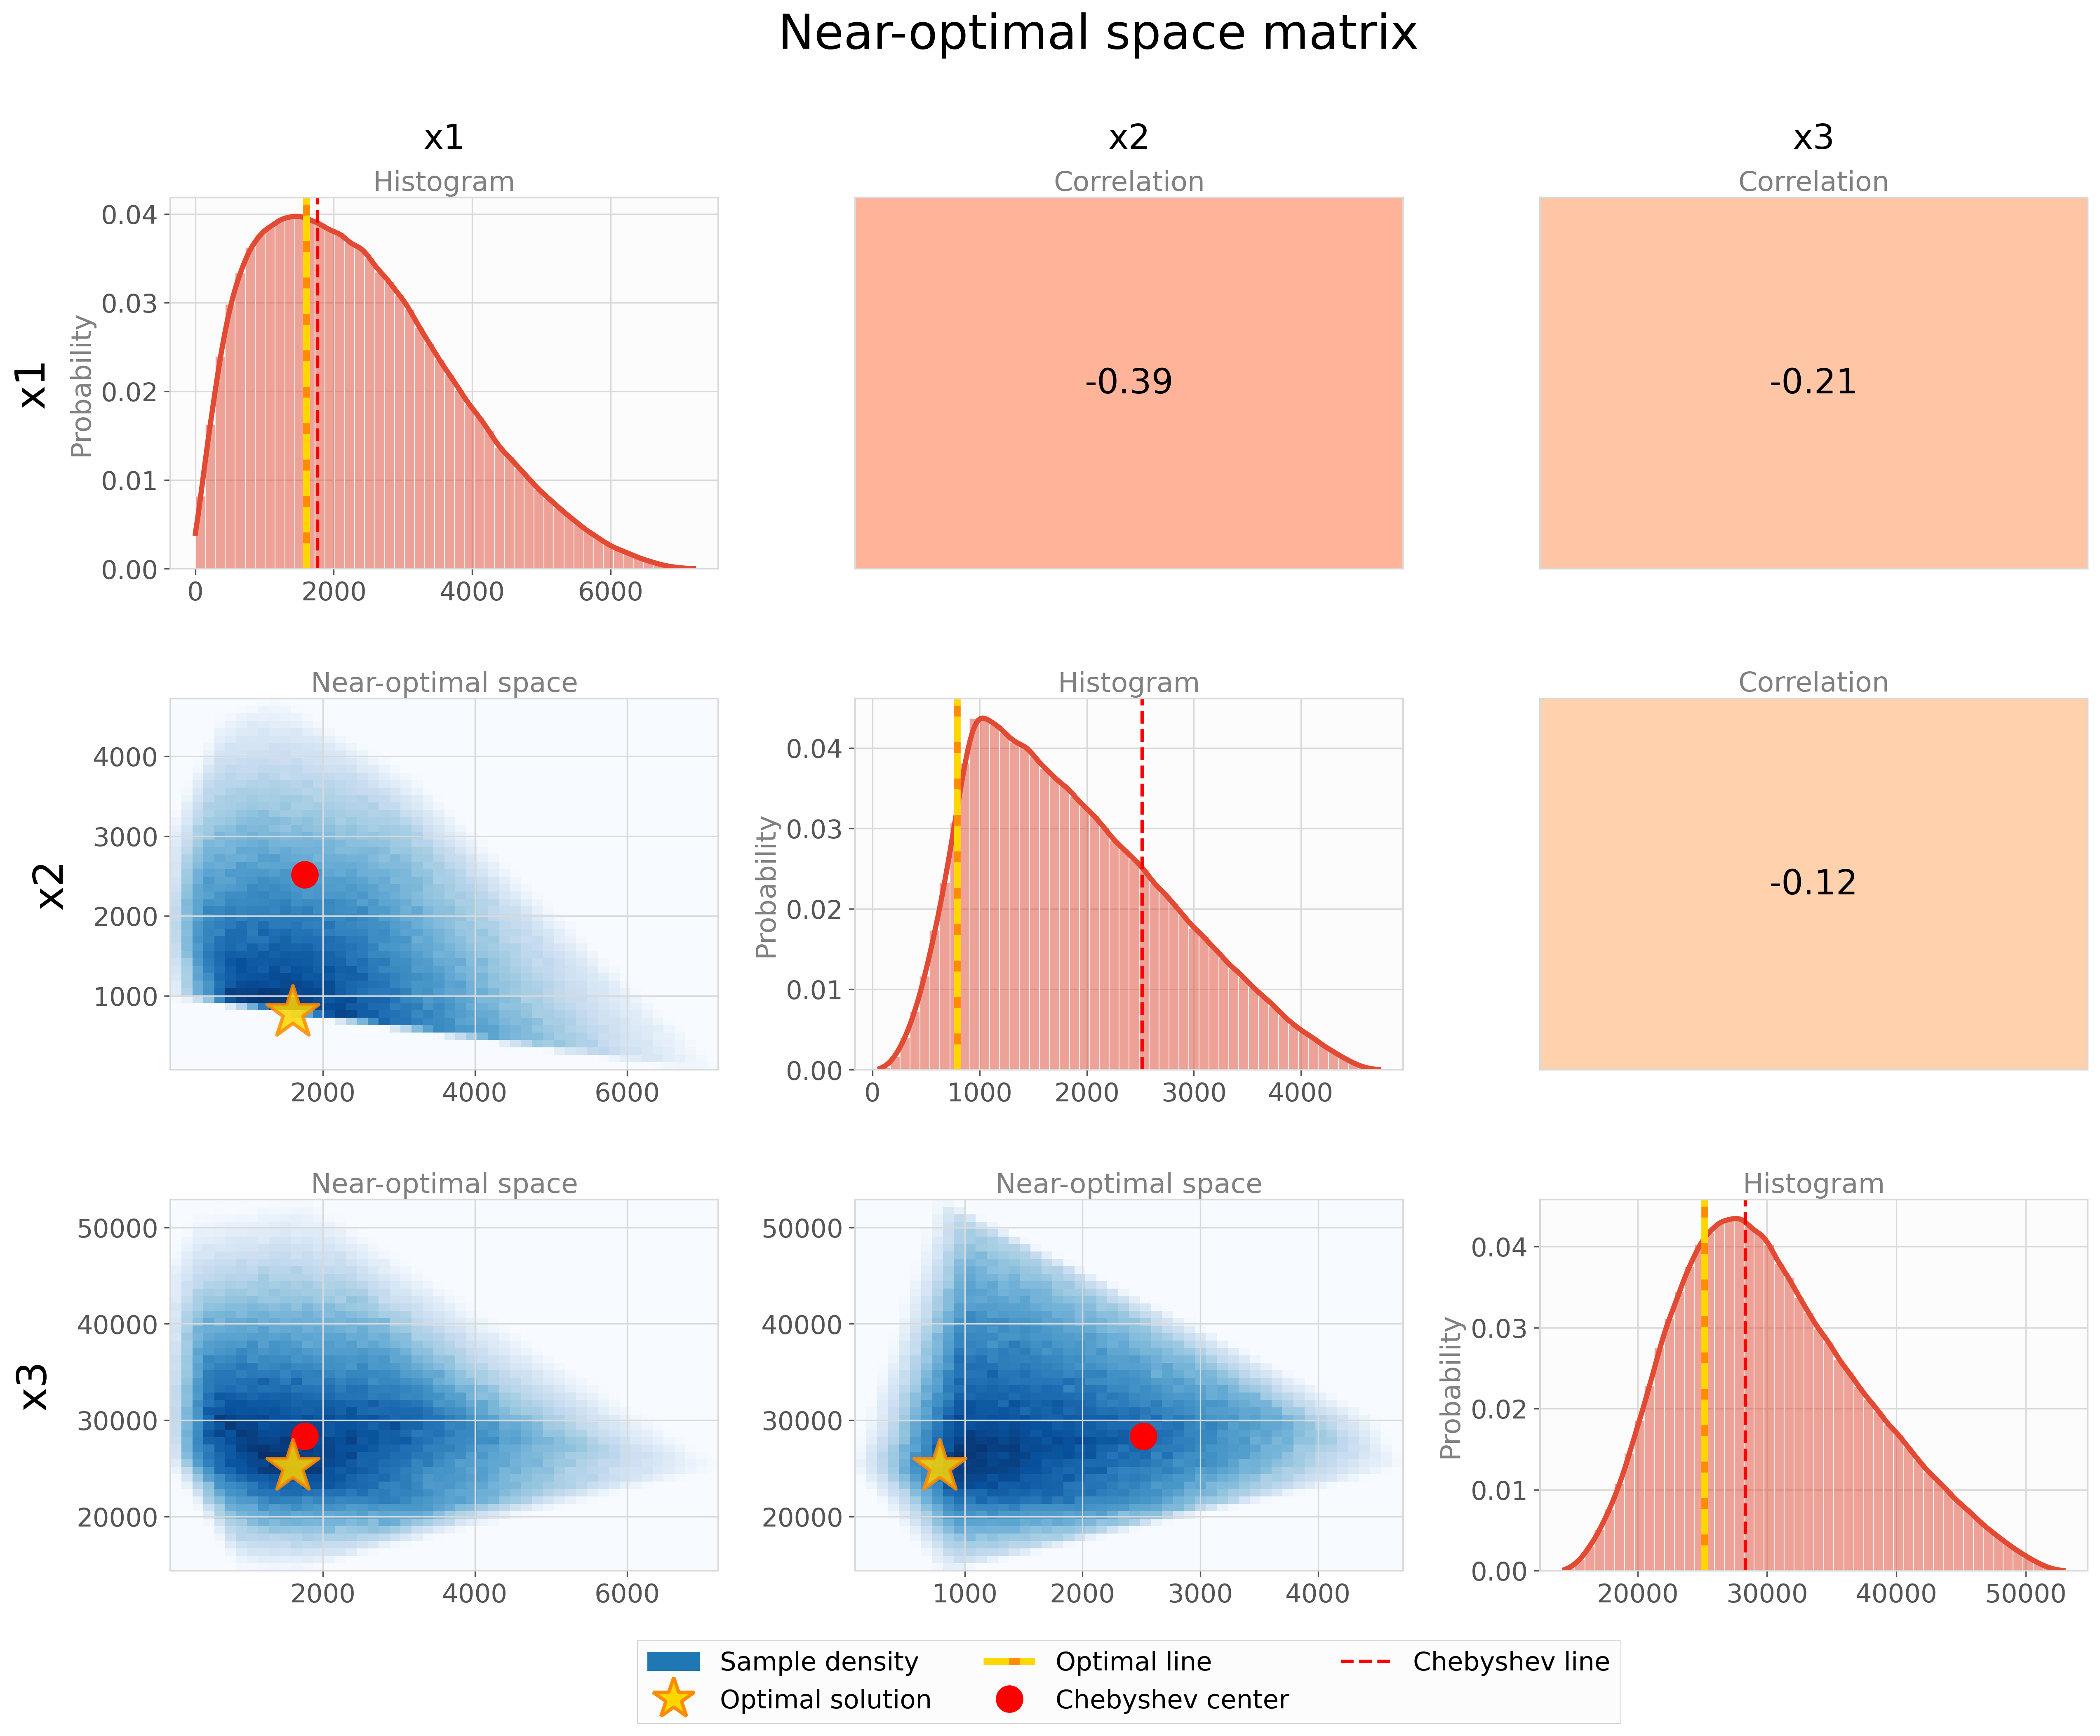

In [8]:
from PyMGA.utilities.plot import near_optimal_space_matrix

# The full near-optimal space matrix
ax, fig = near_optimal_space_matrix(variables = list(variables.keys()), 
                                    vertices = vertices,
                                    samples = samples,
                                    opt_solution = opt_sol,
                                    cheb_center = cheb_center,
                                    plot_boundary = False,
                                    )